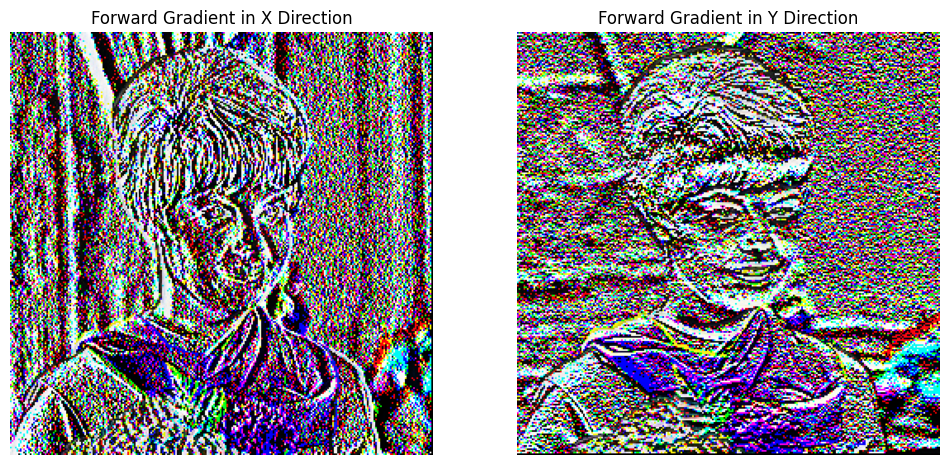

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from poisson_editing import *

image = cv2.imread('C:/Users/laila/Downloads/CV2425_project_week22/CV2425_project_week2/images/lena/girl.png')
grad_i,grad_j = im_fwd_gradient(image)
# Display the gradients
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Forward Gradient in X Direction')
plt.imshow(grad_i, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Forward Gradient in Y Direction')
plt.imshow(grad_j, cmap='gray')
plt.axis('off')

plt.show()

In [2]:
src = cv2.imread('C:/Users/laila/Downloads/CV2425_project_week22/CV2425_project_week2/images/lena/girl.png')
dst = cv2.imread('C:/Users/laila/Downloads/CV2425_project_week22/CV2425_project_week2/images/lena/lena.png')

In [3]:
original_mask = cv2.imread('C:/Users/laila/Downloads/CV2425_project_week22/CV2425_project_week2/images/lena/mask_src_eyes.png', cv2.IMREAD_GRAYSCALE)   # Replace with actual original mask
translated_mask = cv2.imread('C:/Users/laila/Downloads/CV2425_project_week22/CV2425_project_week2/images/lena/mask_dst_eyes.png', cv2.IMREAD_GRAYSCALE)   # Replace with actual translated mask
offset = get_translation(original_mask, translated_mask)


In [6]:
y_max, x_max = dst.shape[:-1]
y_min, x_min = 0, 0
x_range = x_max - x_min
y_range = y_max - y_min

M = np.float32([[1, 0, offset[1]], [0, 1, offset[0]]])
source = cv2.warpAffine(src, M, (x_range, y_range))
translated_image=source

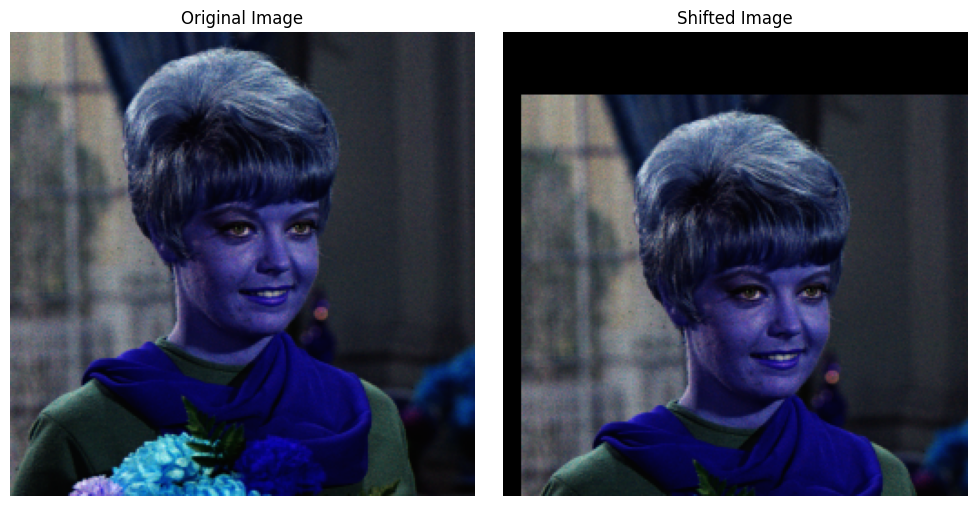

In [7]:
# Plotting the original and shifted images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(src, vmin=0, vmax=9)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Shifted Image")
plt.imshow(translated_image, vmin=0, vmax=9)
plt.axis('off')

plt.tight_layout()
plt.show()

In [8]:
# Load images (ensure they are grayscale)
mask = cv2.imread('C:/Users/laila/Downloads/CV2425_project_week22/CV2425_project_week2/images/lena/mask_dst_eyes.png', cv2.IMREAD_GRAYSCALE) 
mask = mask[y_min:y_max, x_min:x_max]
mask[mask != 0] = 1 
vi, vj = composite_gradients(translated_image, dst, mask)
divergence_result = im_bwd_divergence(vi, vj)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..510.0].


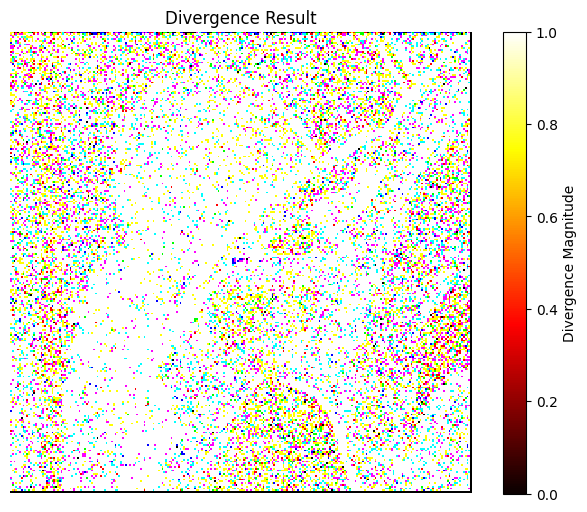

In [9]:
# Plotting the divergence result
plt.figure(figsize=(8, 6))
plt.title('Divergence Result')
plt.imshow(divergence_result, cmap='hot', interpolation='nearest')
plt.colorbar(label='Divergence Magnitude')
plt.axis('off')  # Turn off axis
plt.show()

In [13]:
import numpy as np
import cv2
from scipy import sparse
from scipy.sparse.linalg import cg


# Load masks
original_mask = cv2.imread('C:/Users/laila/Downloads/CV2425_project_week22/CV2425_project_week2/images/lena/mask_src_eyes.png', cv2.IMREAD_GRAYSCALE)
translated_mask = cv2.imread('C:/Users/laila/Downloads/CV2425_project_week22/CV2425_project_week2/images/lena/mask_dst_eyes.png', cv2.IMREAD_GRAYSCALE)
offset = get_translation(original_mask, translated_mask)


u_comb = np.zeros_like(dst)  # Combined image

for channel in range(3):
    f = dst[:, :, channel]
    y_max, x_max = f.shape
    y_min, x_min = 0, 0

    # Translate the image
    M = np.float32([[1, 0, offset[1]], [0, 1, offset[0]]])
    source = cv2.warpAffine(src, M, (x_max, y_max))  # Corrected size
    m = translated_mask

    u = u_comb[:, :, channel]
    u1 = source[:, :, channel]  # Use the updated source

    beta_0 = 1   # Adjust as necessary
    beta = beta_0 * (1 - m)

    m = m[y_min:y_max, x_min:x_max]
    m[m != 0] = 1 
    vi, vj = composite_gradients(u1, f, m)

    # Construct the right-hand side b
    b = np.zeros_like(u)
    b = im_bwd_divergence(vi, vj)

    height, width = f.shape
    size = height * width
    
    # Create a sparse matrix A
    A_rows = []
    A_cols = []
    A_data = []

    for i in range(height):
        for j in range(width):
            if i == 0 or i == height - 1 or j == 0 or j == width - 1:
                continue  # Skip boundary pixels
            
            index = i * width + j
            A_rows.append(index)
            A_cols.append(index)
            A_data.append(-4)

            for di, dj in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                ni, nj = i + di, j + dj
                if 0 <= ni < height and 0 <= nj < width:
                    nindex = ni * width + nj
                    A_rows.append(index)
                    A_cols.append(nindex)
                    A_data.append(1)

    A = sparse.csr_matrix((A_data, (A_rows, A_cols)), shape=(size, size))
    
    # Solve the linear system A * u_final = b
    u_final_flat, info = cg(A, b.flatten())

    # Store the result in the combined image
    u_comb[:, :, channel] = u_final_flat.reshape((height, width))



C:\Users\laila\AppData\Local\Temp\ipykernel_27856\2917356109.py:71: RuntimeWarning: invalid value encountered in cast
  u_comb[:, :, channel] = u_final_flat.reshape((height, width))


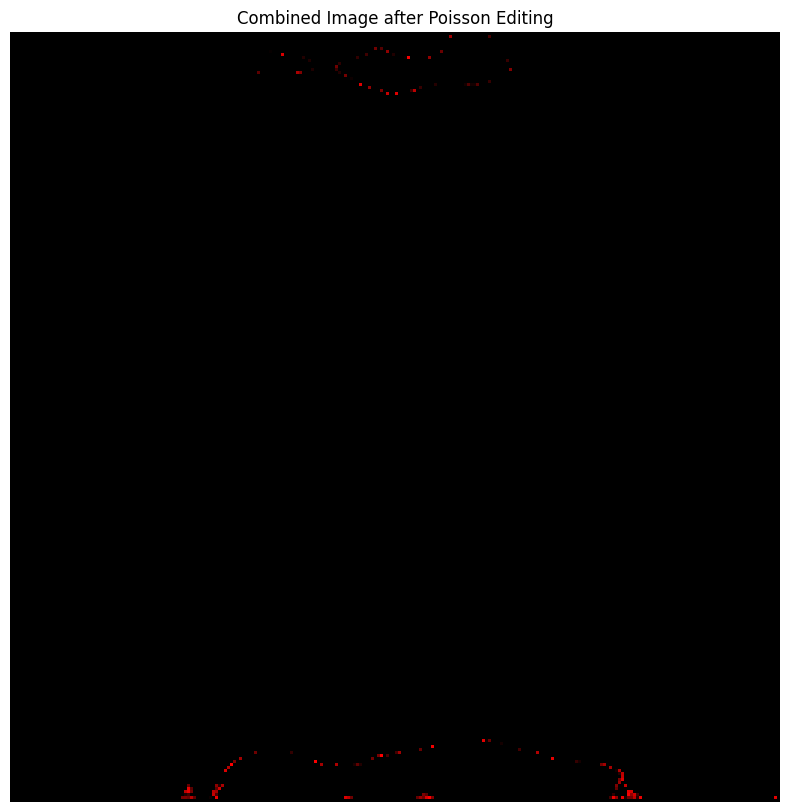

In [14]:
# Plotting
plt.figure(figsize=(10, 10))
plt.imshow(u_comb)  # Use imshow to display the image
plt.axis('off')  # Turn off axis
plt.title("Combined Image after Poisson Editing")
plt.show()